In [1]:
!pip install torch torchvision torchaudio torch-geometric pandas scikit-learn pandas numpy scipy networkx

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/44/80/b353c024e6b624cd9ce1d66dcb9d24e0294680f95b369f19280e241a0159/torch-2.7.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/99/94/a015e93955f5d3a68689cc7c385a3cfcd2d62b84655d18b61f32fb04eb67/torchvision-0.22.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/5e/23/b73163ac06e5a724375df61a5b6c853861a825fe98e64388f277514153dd/torchaudio-2.7.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for torch-geometric from https://files.pythonhosted.org/packages/03/9f/157e913626c1acfb3b19ce000b1a6e4e4fb177c0bc0ea0c67ca5bd714b5a/torch_geometric-2.6.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/63.1 kB ? eta -:--:--
     ---------------------------------------- 63.1/63.1 kB ? eta 0:00:00
  Obt


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import scipy as sp

df = pd.read_csv("../datasets/train_test_network.csv")
df.head()


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [3]:
label_counts = df['label'].value_counts()
print(f"Label 0 (Normal): {label_counts.get(0, 0)}")
print(f"Label 1 (Attack): {label_counts.get(1, 0)}")

Label 0 (Normal): 50000
Label 1 (Attack): 161043


## Graph Structure - Heterogeneous Graph 


| Element            | What You Use From Dataset                              |
| ------------------ | ------------------------------------------------------ |
| **Nodes**          | IP addresses from `src_ip` and `dst_ip`                |
| **Edges**          | One edge per connection or flow from `src_ip → dst_ip` |
| **Directionality** | Yes – flows are directed from source to destination    |
| **Edge Weight**    | Optional – could be frequency, total bytes, etc.       |

Recommended Edge Attributes:
- **proto** (TCP/UDP/ICMP)
- **service** (HTTP, DNS, SSL, etc.)
- **duration** (length of the flow in seconds)
- **src_bytes** / dst_bytes (payload size per direction)
- **conn_state** (S0, S1, REJ — Zeek flow state)
- **missed_bytes** (for gap analysis)
- **label** (0 = normal, 1 = attack)
- **type** (attack category, e.g., DDoS, DoS, backdoor)
- **timestamp** (ts) – useful for graph evolution

In [4]:
from sklearn.preprocessing import LabelEncoder

df = df.dropna(subset=["src_ip", "dst_ip", "label"])

ip_encoder = LabelEncoder()
all_ips = pd.concat([df["src_ip"], df["dst_ip"]])
ip_encoder.fit(all_ips)
df["src_id"] = ip_encoder.transform(df["src_ip"])
df["dst_id"] = ip_encoder.transform(df["dst_ip"])

num_nodes = len(ip_encoder.classes_)

In [5]:
from sklearn.preprocessing import StandardScaler

features = np.zeros((num_nodes, 5))  
labels = np.zeros(num_nodes)

for ip_id in range(num_nodes):
    rows = df[(df["src_id"] == ip_id) | (df["dst_id"] == ip_id)]
    features[ip_id, 0] = rows["src_bytes"].sum()
    features[ip_id, 1] = rows["dst_bytes"].sum()
    features[ip_id, 2] = rows["duration"].mean()
    features[ip_id, 3] = rows["proto"].nunique()
    features[ip_id, 4] = rows["service"].nunique()
    
    # Label as attack if it ever participated in an attack
    if (rows["label"] == 1).any():
        labels[ip_id] = 1  # attacker
    else:
        labels[ip_id] = 0  # normal

# Normalize features
features = StandardScaler().fit_transform(features)


In [6]:
import torch
import torch_geometric

edge_index = torch.tensor(df[["src_id", "dst_id"]].values.T, dtype=torch.long)

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

In [7]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)

In [8]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [9]:
from torch_geometric.utils import train_test_split_edges

train_mask = torch.rand(len(y)) < 0.8
test_mask = ~train_mask

model = GCN(input_dim=x.shape[1], hidden_dim=16, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
loss_fn = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[train_mask], y[train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.8824
Epoch 10, Loss: 0.5565
Epoch 20, Loss: 0.4727
Epoch 30, Loss: 0.3990
Epoch 40, Loss: 0.3179
Epoch 50, Loss: 0.2456
Epoch 60, Loss: 0.1935
Epoch 70, Loss: 0.1651
Epoch 80, Loss: 0.1499
Epoch 90, Loss: 0.1412
Epoch 100, Loss: 0.1355
Epoch 110, Loss: 0.1316
Epoch 120, Loss: 0.1278
Epoch 130, Loss: 0.1247
Epoch 140, Loss: 0.1222
Epoch 150, Loss: 0.1201
Epoch 160, Loss: 0.1175
Epoch 170, Loss: 0.1151
Epoch 180, Loss: 0.1128
Epoch 190, Loss: 0.1108


In [10]:
model.eval()
pred = model(data).argmax(dim=1)

from sklearn.metrics import classification_report
print(classification_report(y[test_mask], pred[test_mask], target_names=["Normal", "Attack"]))

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96       103
      Attack       0.91      0.91      0.91        47

    accuracy                           0.95       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.95      0.95      0.95       150



In [4]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# --- Load balanced dataset ---
df = pd.read_csv("../datasets/balanced_train_test_network.csv")

# --- Data prep ---
df = df.dropna(subset=["src_ip", "dst_ip", "label"])
df["label"] = df["label"].astype(int)

ip_encoder = LabelEncoder()
all_ips = pd.concat([df["src_ip"], df["dst_ip"]])
ip_encoder.fit(all_ips)
df["src_id"] = ip_encoder.transform(df["src_ip"])
df["dst_id"] = ip_encoder.transform(df["dst_ip"])

num_nodes = len(ip_encoder.classes_)

features = np.zeros((num_nodes, 5))
labels = np.zeros(num_nodes)

for ip_id in range(num_nodes):
    rows = df[(df["src_id"] == ip_id) | (df["dst_id"] == ip_id)]
    features[ip_id, 0] = rows["src_bytes"].sum()
    features[ip_id, 1] = rows["dst_bytes"].sum()
    features[ip_id, 2] = rows["duration"].mean()
    features[ip_id, 3] = rows["proto"].nunique()
    features[ip_id, 4] = rows["service"].nunique()
    labels[ip_id] = 1 if (rows["label"] == 1).any() else 0

features = StandardScaler().fit_transform(features)

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)
edge_index = torch.tensor(df[["src_id", "dst_id"]].values.T, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# --- GCN Model Definition ---
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# --- Train and Evaluate ---
def train_and_eval(data, train_idx, test_idx):
    model = GCN(input_dim=data.x.shape[1], hidden_dim=16, output_dim=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out[train_idx], y[train_idx])
        loss.backward()
        optimizer.step()

    model.eval()
    preds = model(data).argmax(dim=1)
    report = classification_report(
        y[test_idx].cpu(),
        preds[test_idx].cpu(),
        target_names=["Normal", "Attack"],
        zero_division=0,
    )
    print("Balanced Dataset Report:")
    print(report)



# --- Split for balanced evaluation ---
torch.manual_seed(42)
all_idx = torch.arange(len(y))
perm = torch.randperm(len(y))
train_idx = perm[:int(0.8 * len(y))]
test_idx = perm[int(0.8 * len(y)):]
train_and_eval(data, train_idx, test_idx)

Balanced Dataset Report:
              precision    recall  f1-score   support

      Normal       0.95      0.96      0.96       107
      Attack       0.88      0.85      0.86        33

    accuracy                           0.94       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.94      0.94      0.94       140



In [6]:
from sklearn.model_selection import StratifiedKFold


def run_cross_validation(data, x, y, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_scores = []
    acc_scores = []

    print(f"\n--- {k}-Fold Cross Validation ---")
    for fold, (train_idx_np, test_idx_np) in enumerate(skf.split(x, y)):
        train_idx = torch.tensor(train_idx_np, dtype=torch.long)
        test_idx = torch.tensor(test_idx_np, dtype=torch.long)

        model = GCN(input_dim=x.shape[1], hidden_dim=16, output_dim=2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
        loss_fn = torch.nn.CrossEntropyLoss()

        # Train
        for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = loss_fn(out[train_idx], y[train_idx])
            loss.backward()
            optimizer.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            out = model(data)
            preds = out[test_idx].argmax(dim=1)
            true = y[test_idx]
            report = classification_report(true.cpu(), preds.cpu(), target_names=["Normal", "Attack"], output_dict=True, zero_division=0)
            acc = report["accuracy"]
            f1 = report["weighted avg"]["f1-score"]
            acc_scores.append(acc)
            f1_scores.append(f1)

            print(f"Fold {fold + 1}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

    print(f"\nAverage Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f}")

# Run CV5 and CV10
run_cross_validation(data, x, y, k=5)
run_cross_validation(data, x, y, k=10)


--- 5-Fold Cross Validation ---
Fold 1: Accuracy = 0.9571, F1 = 0.9552
Fold 2: Accuracy = 0.9640, F1 = 0.9627
Fold 3: Accuracy = 0.9065, F1 = 0.8997
Fold 4: Accuracy = 0.9281, F1 = 0.9236
Fold 5: Accuracy = 0.8417, F1 = 0.8169

Average Accuracy: 0.9195
Average F1 Score: 0.9116

--- 10-Fold Cross Validation ---
Fold 1: Accuracy = 0.9857, F1 = 0.9855
Fold 2: Accuracy = 0.9143, F1 = 0.9058
Fold 3: Accuracy = 0.9000, F1 = 0.8958
Fold 4: Accuracy = 0.9429, F1 = 0.9413
Fold 5: Accuracy = 0.8571, F1 = 0.8430
Fold 6: Accuracy = 0.9571, F1 = 0.9551
Fold 7: Accuracy = 0.9420, F1 = 0.9403
Fold 8: Accuracy = 0.9565, F1 = 0.9545
Fold 9: Accuracy = 0.8986, F1 = 0.8847
Fold 10: Accuracy = 0.9130, F1 = 0.9034

Average Accuracy: 0.9267
Average F1 Score: 0.9209


In [7]:
label_counts = df['label'].value_counts()
print(f"Label 0 (Normal): {label_counts.get(0, 0)}")
print(f"Label 1 (Attack): {label_counts.get(1, 0)}")

Label 0 (Normal): 50000
Label 1 (Attack): 50000


In [10]:
!pip install matplotlib seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


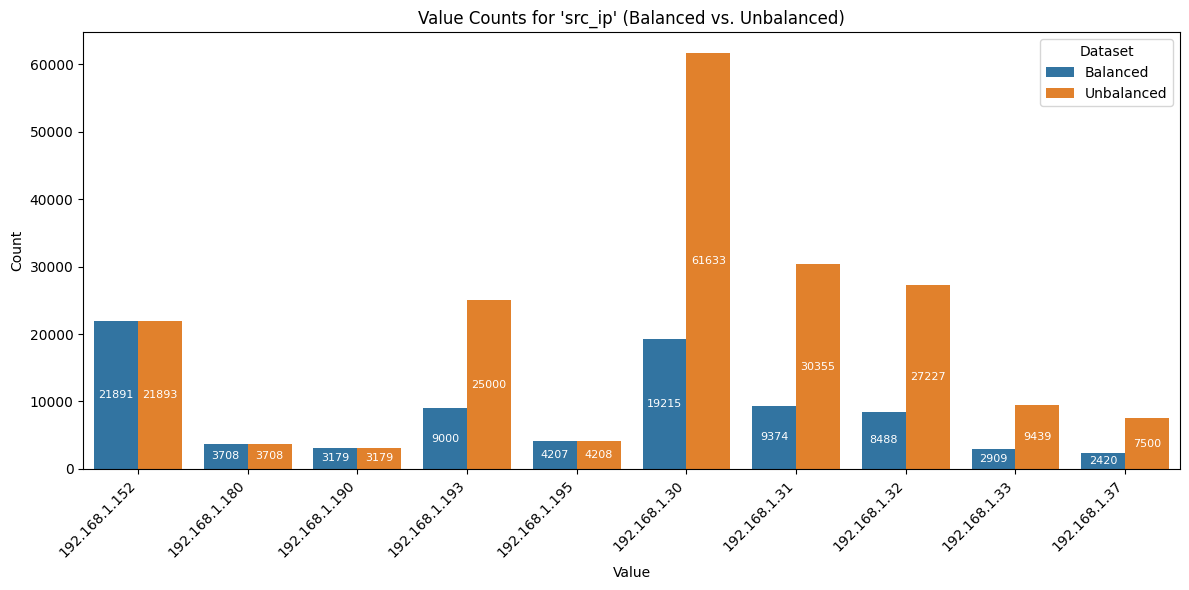

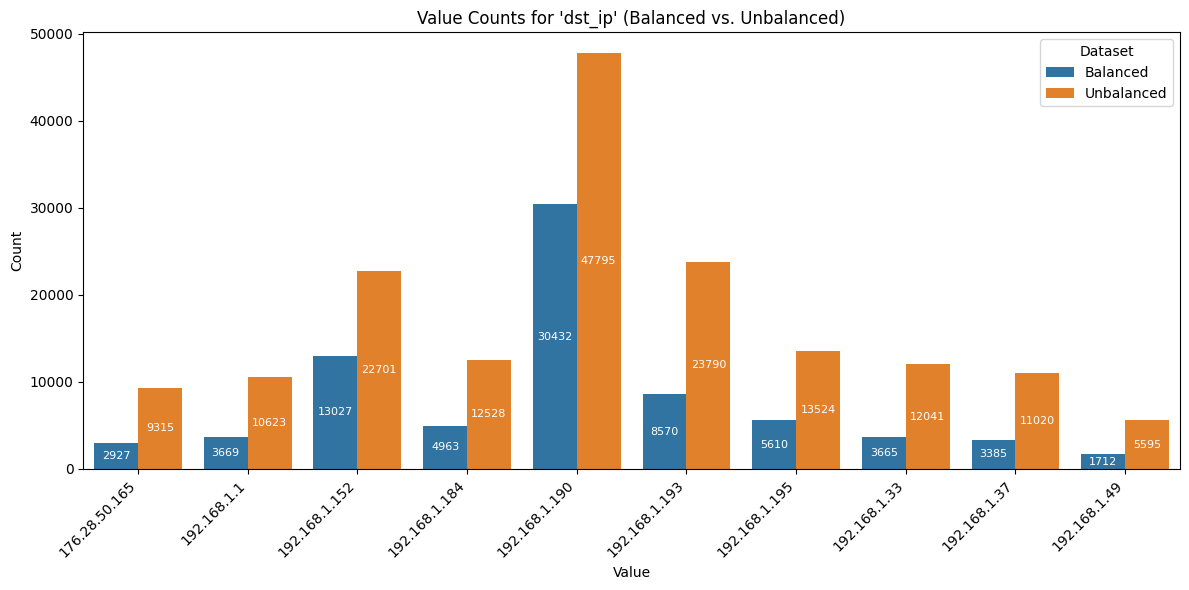

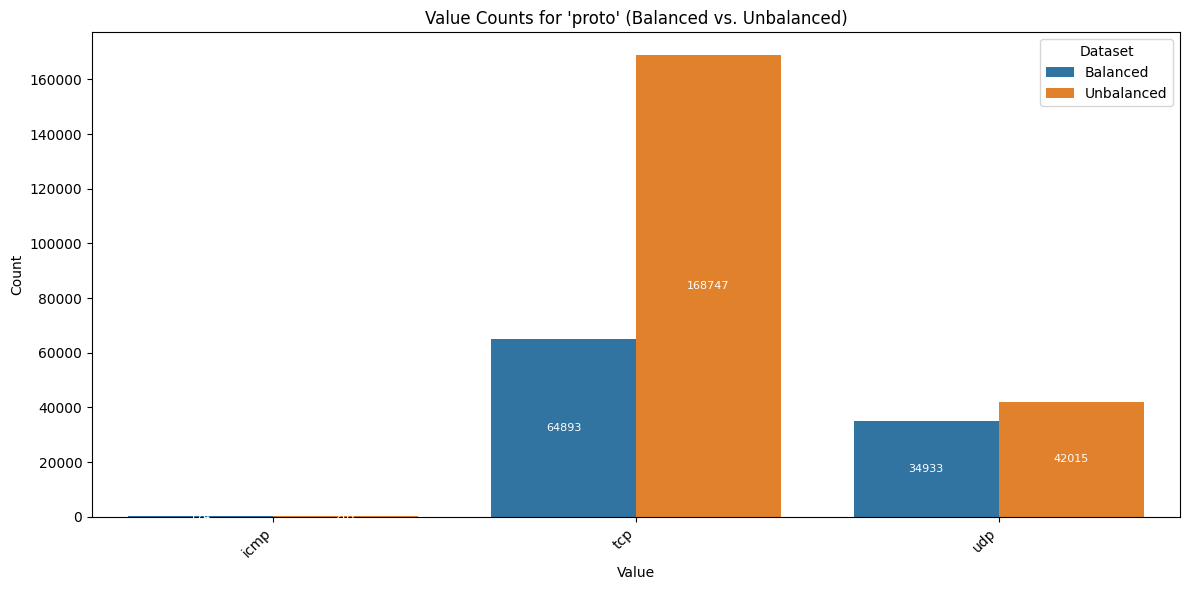

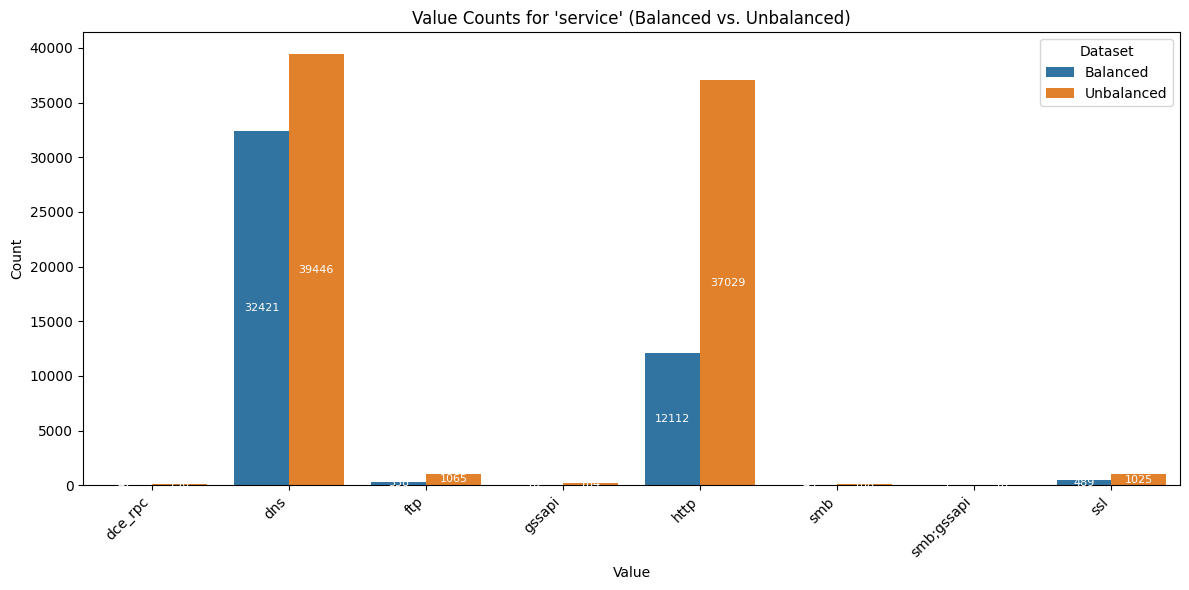

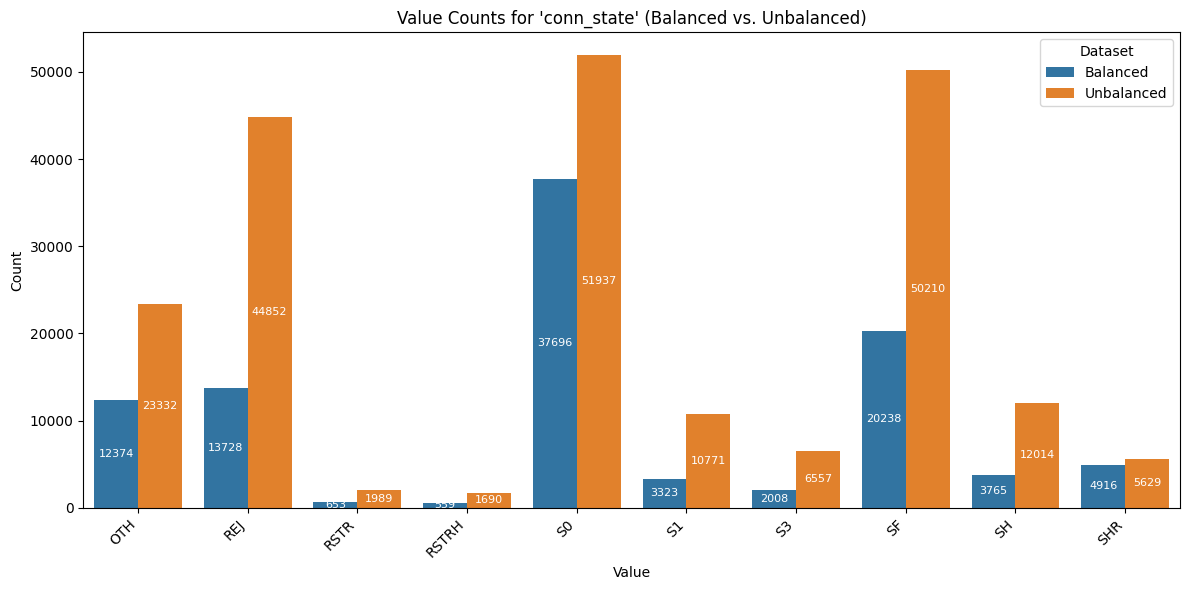

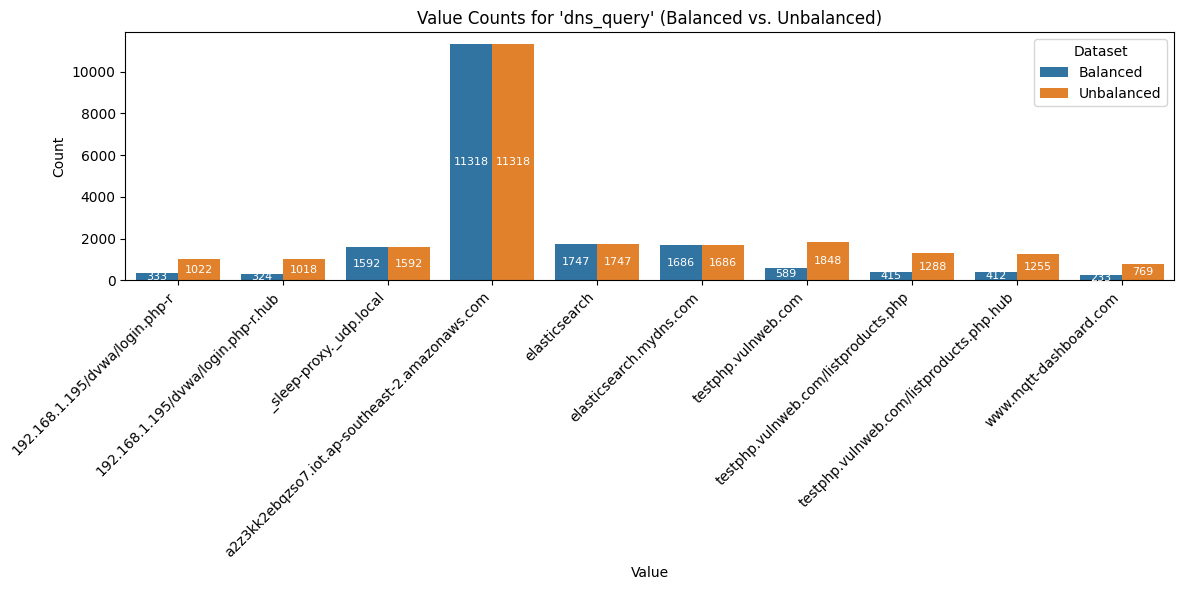

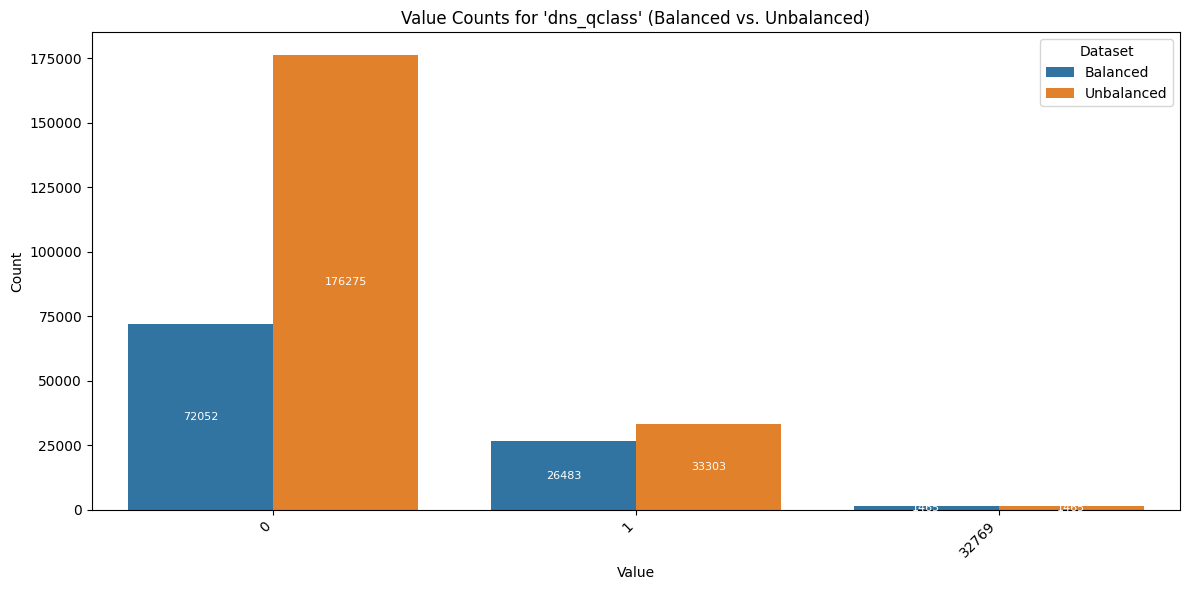

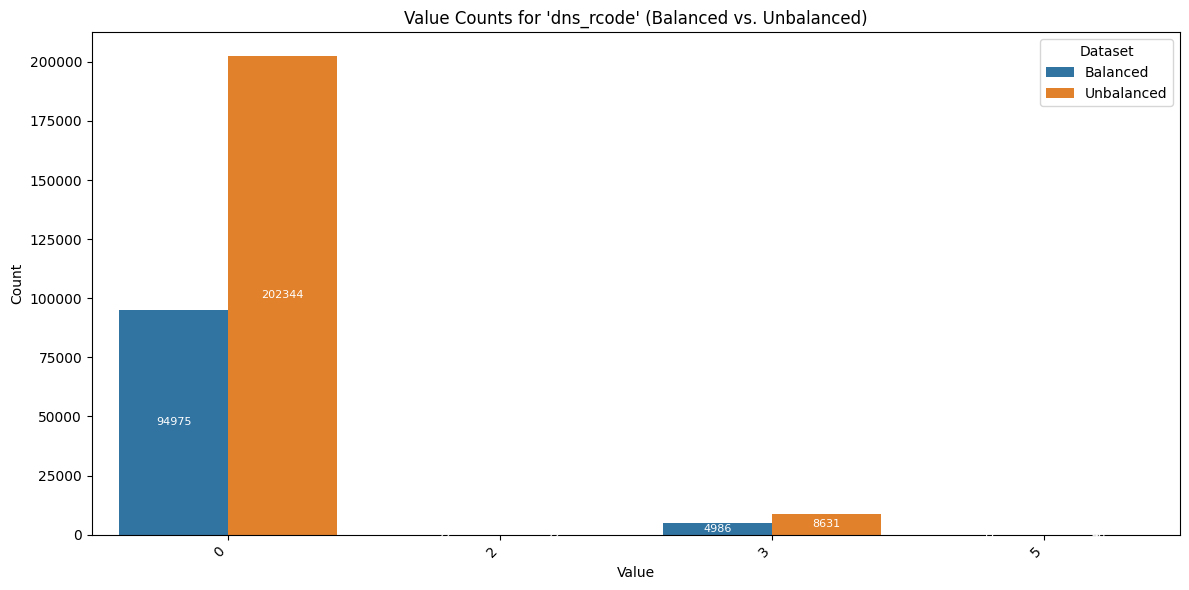

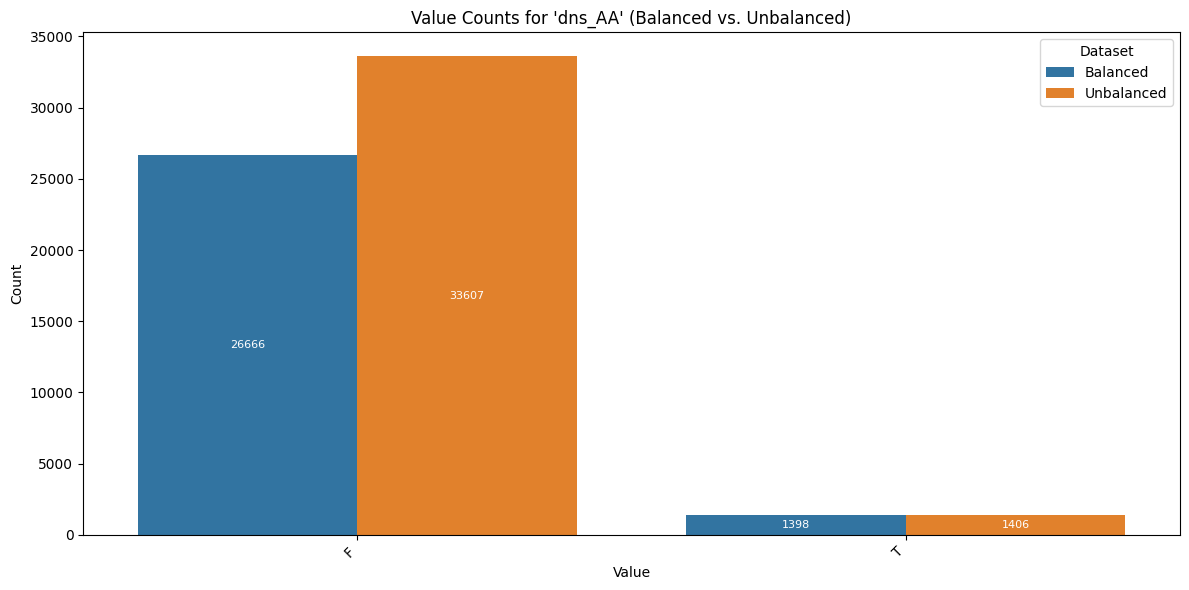

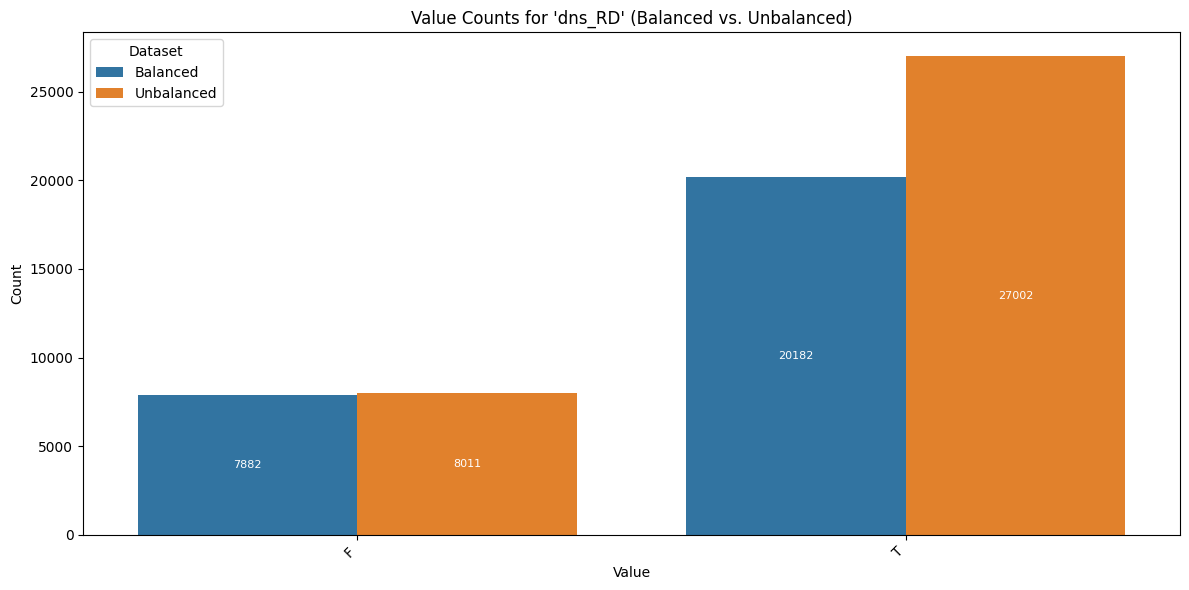

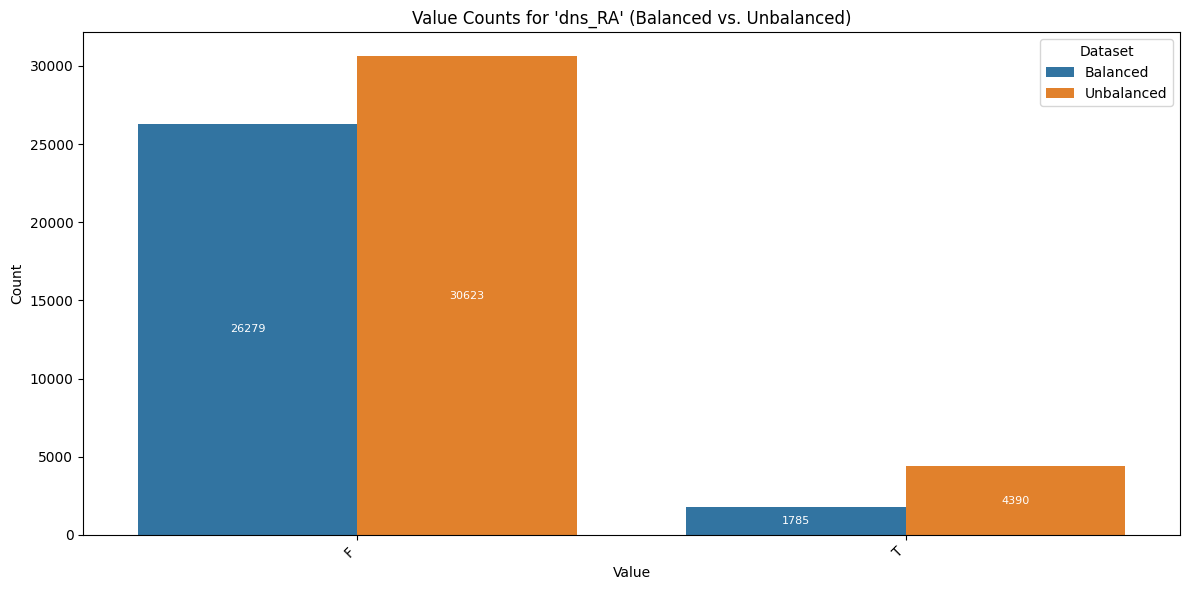

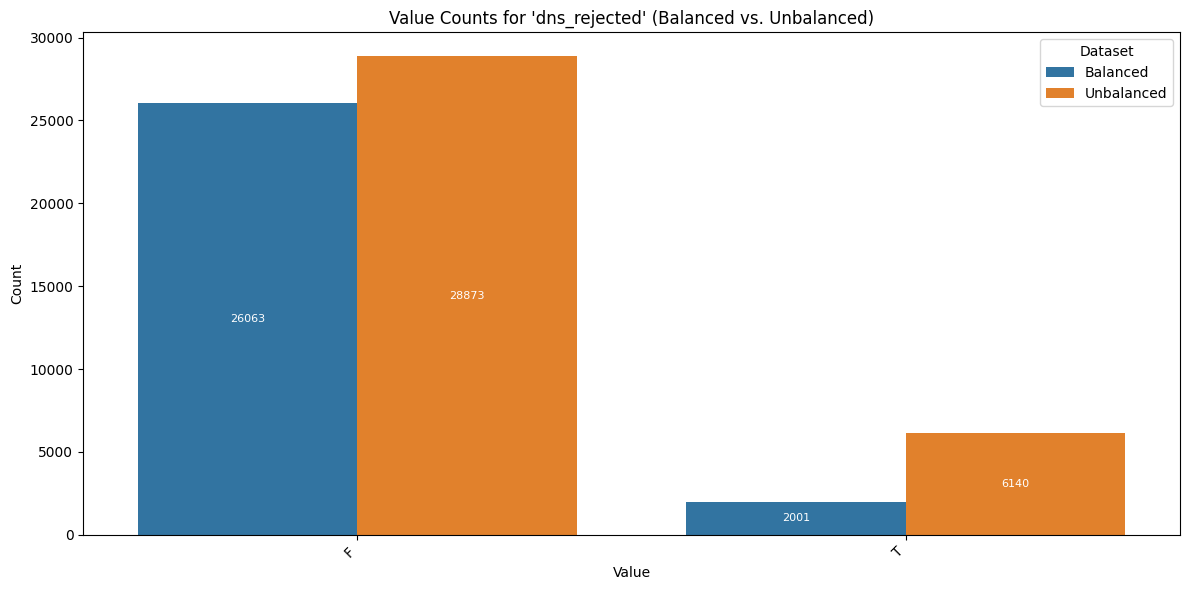

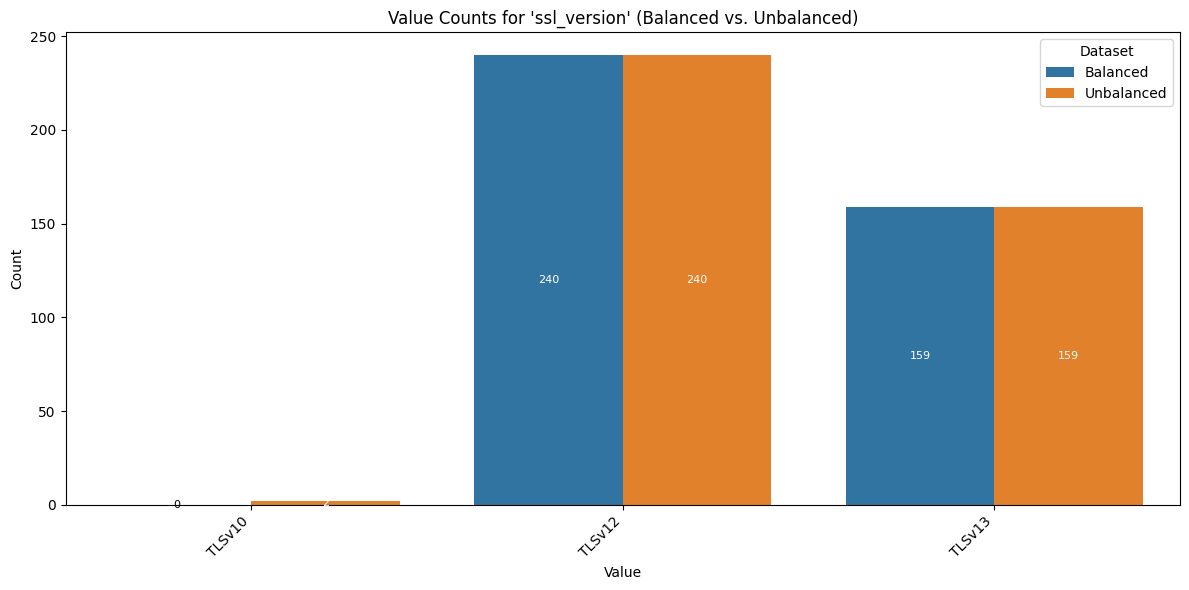

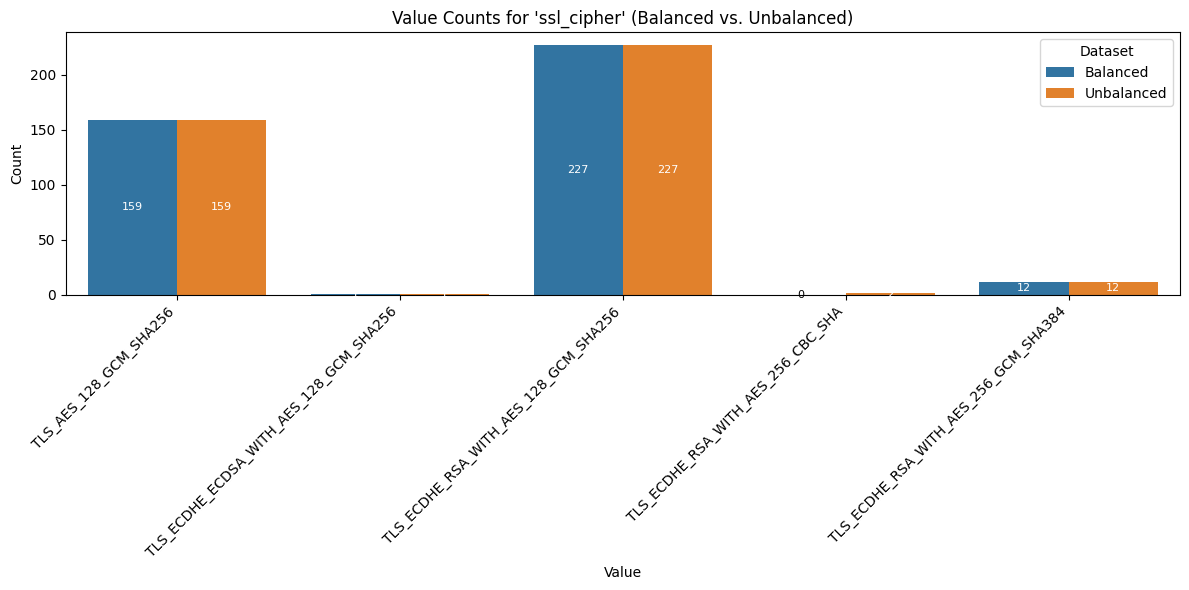

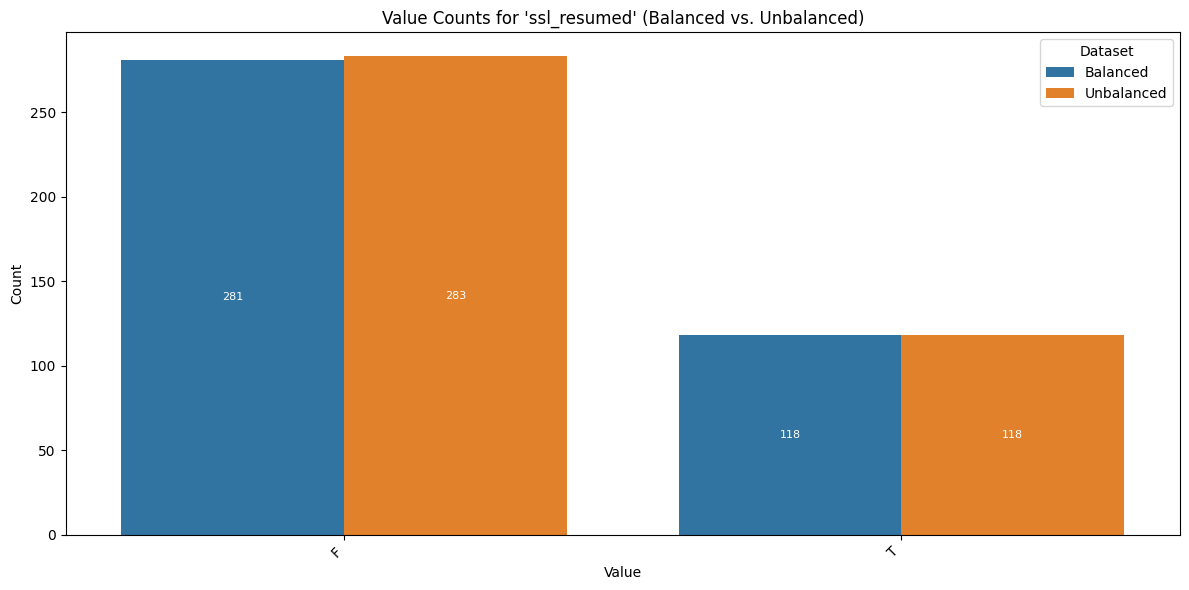

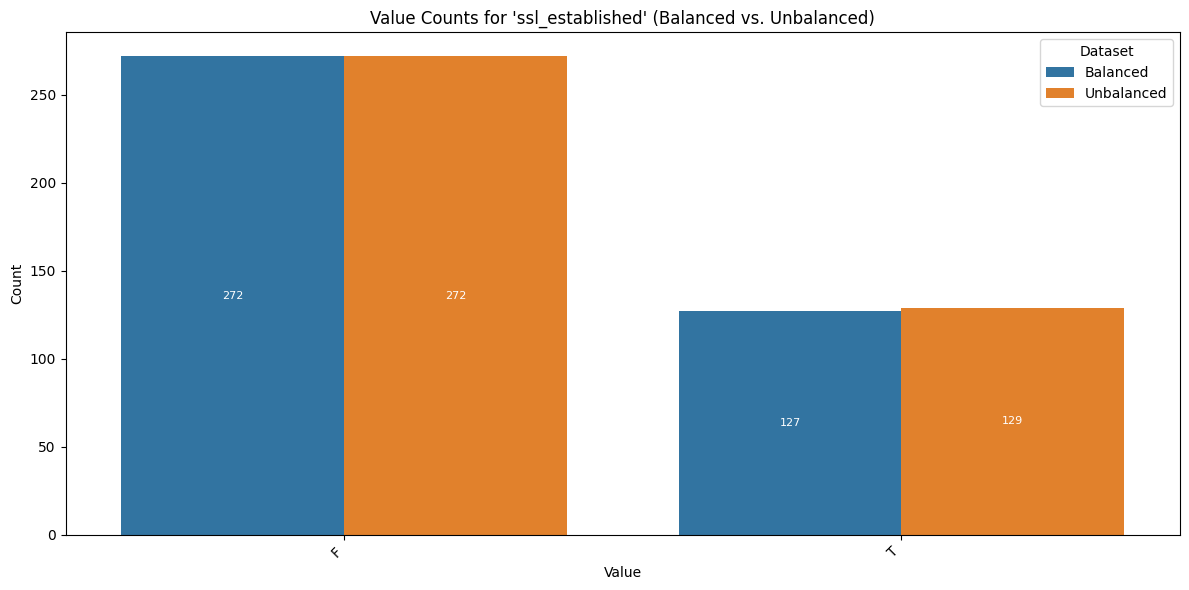

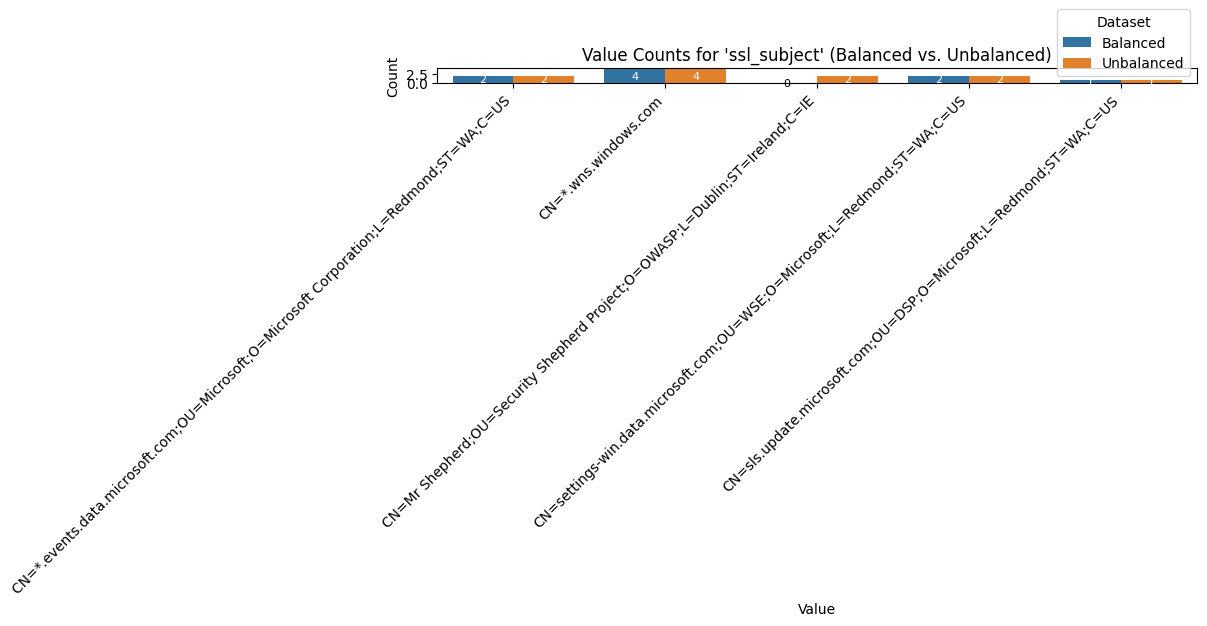

C:\Users\marko\AppData\Local\Temp\ipykernel_24012\292403275.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


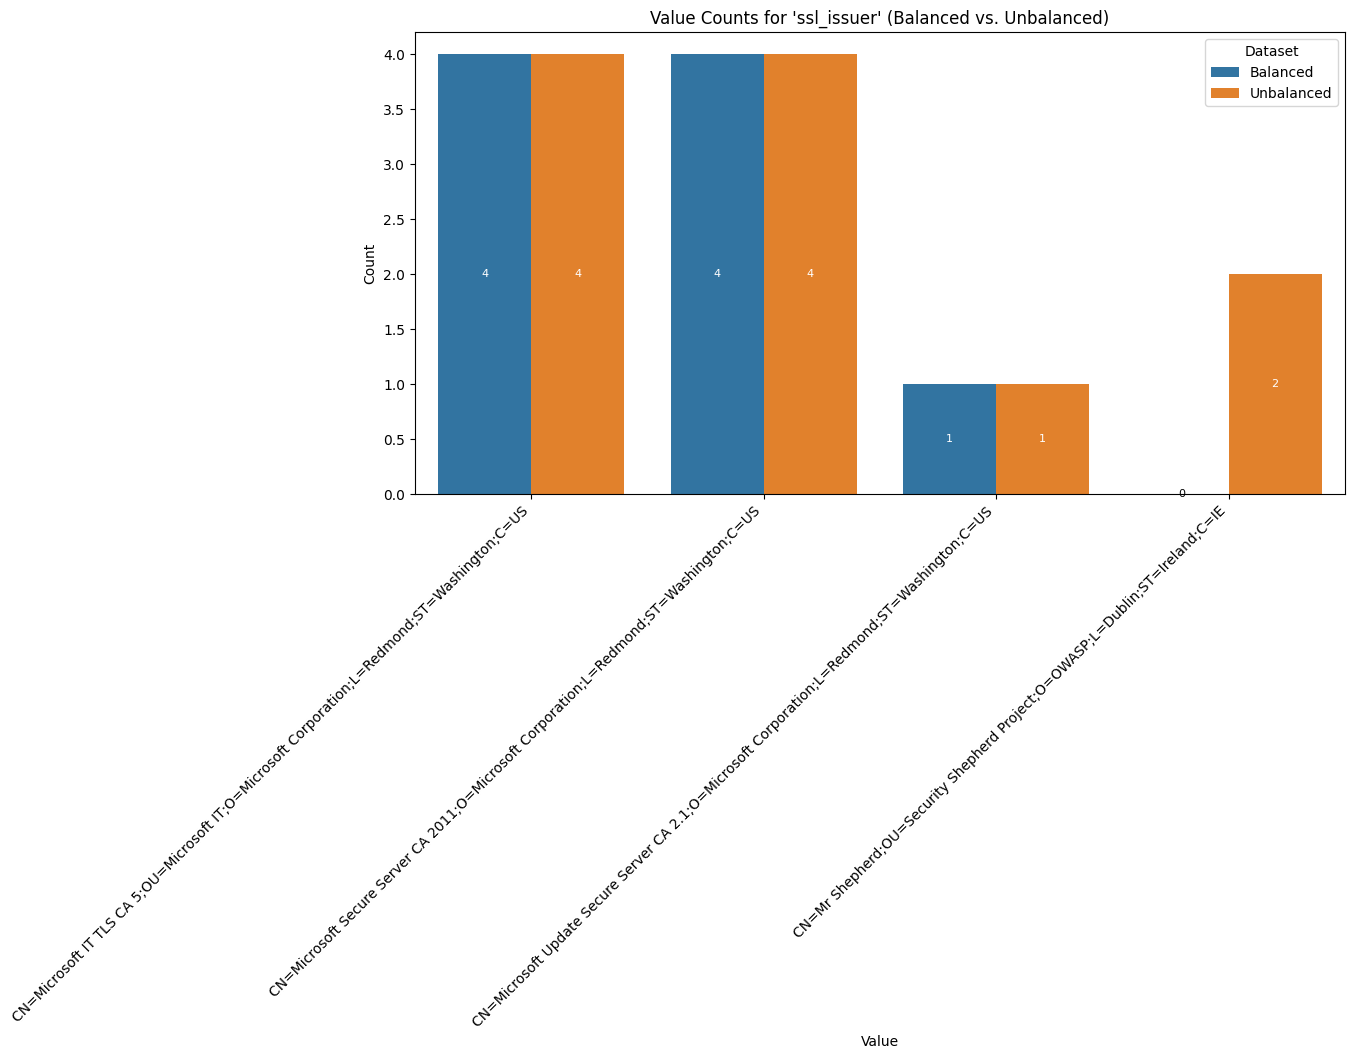

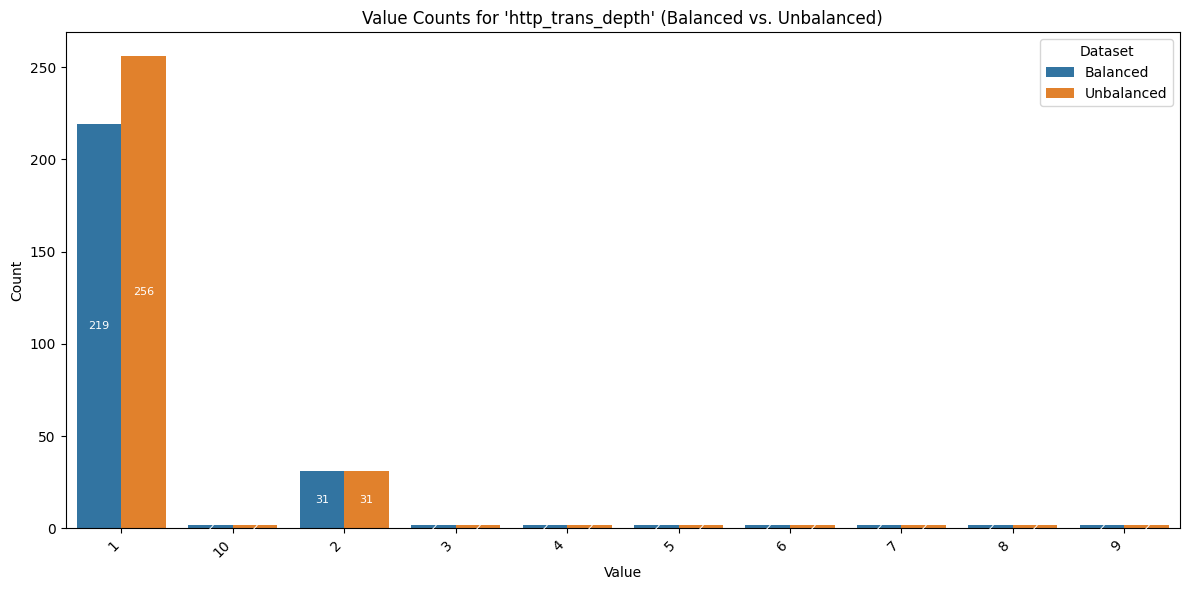

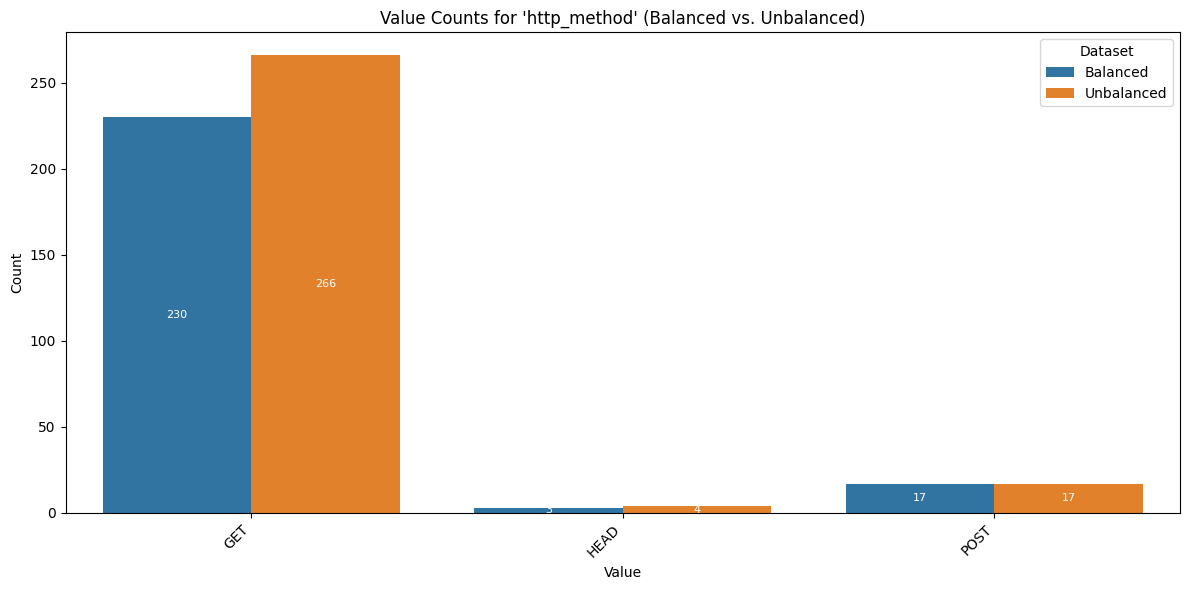

C:\Users\marko\AppData\Local\Temp\ipykernel_24012\292403275.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


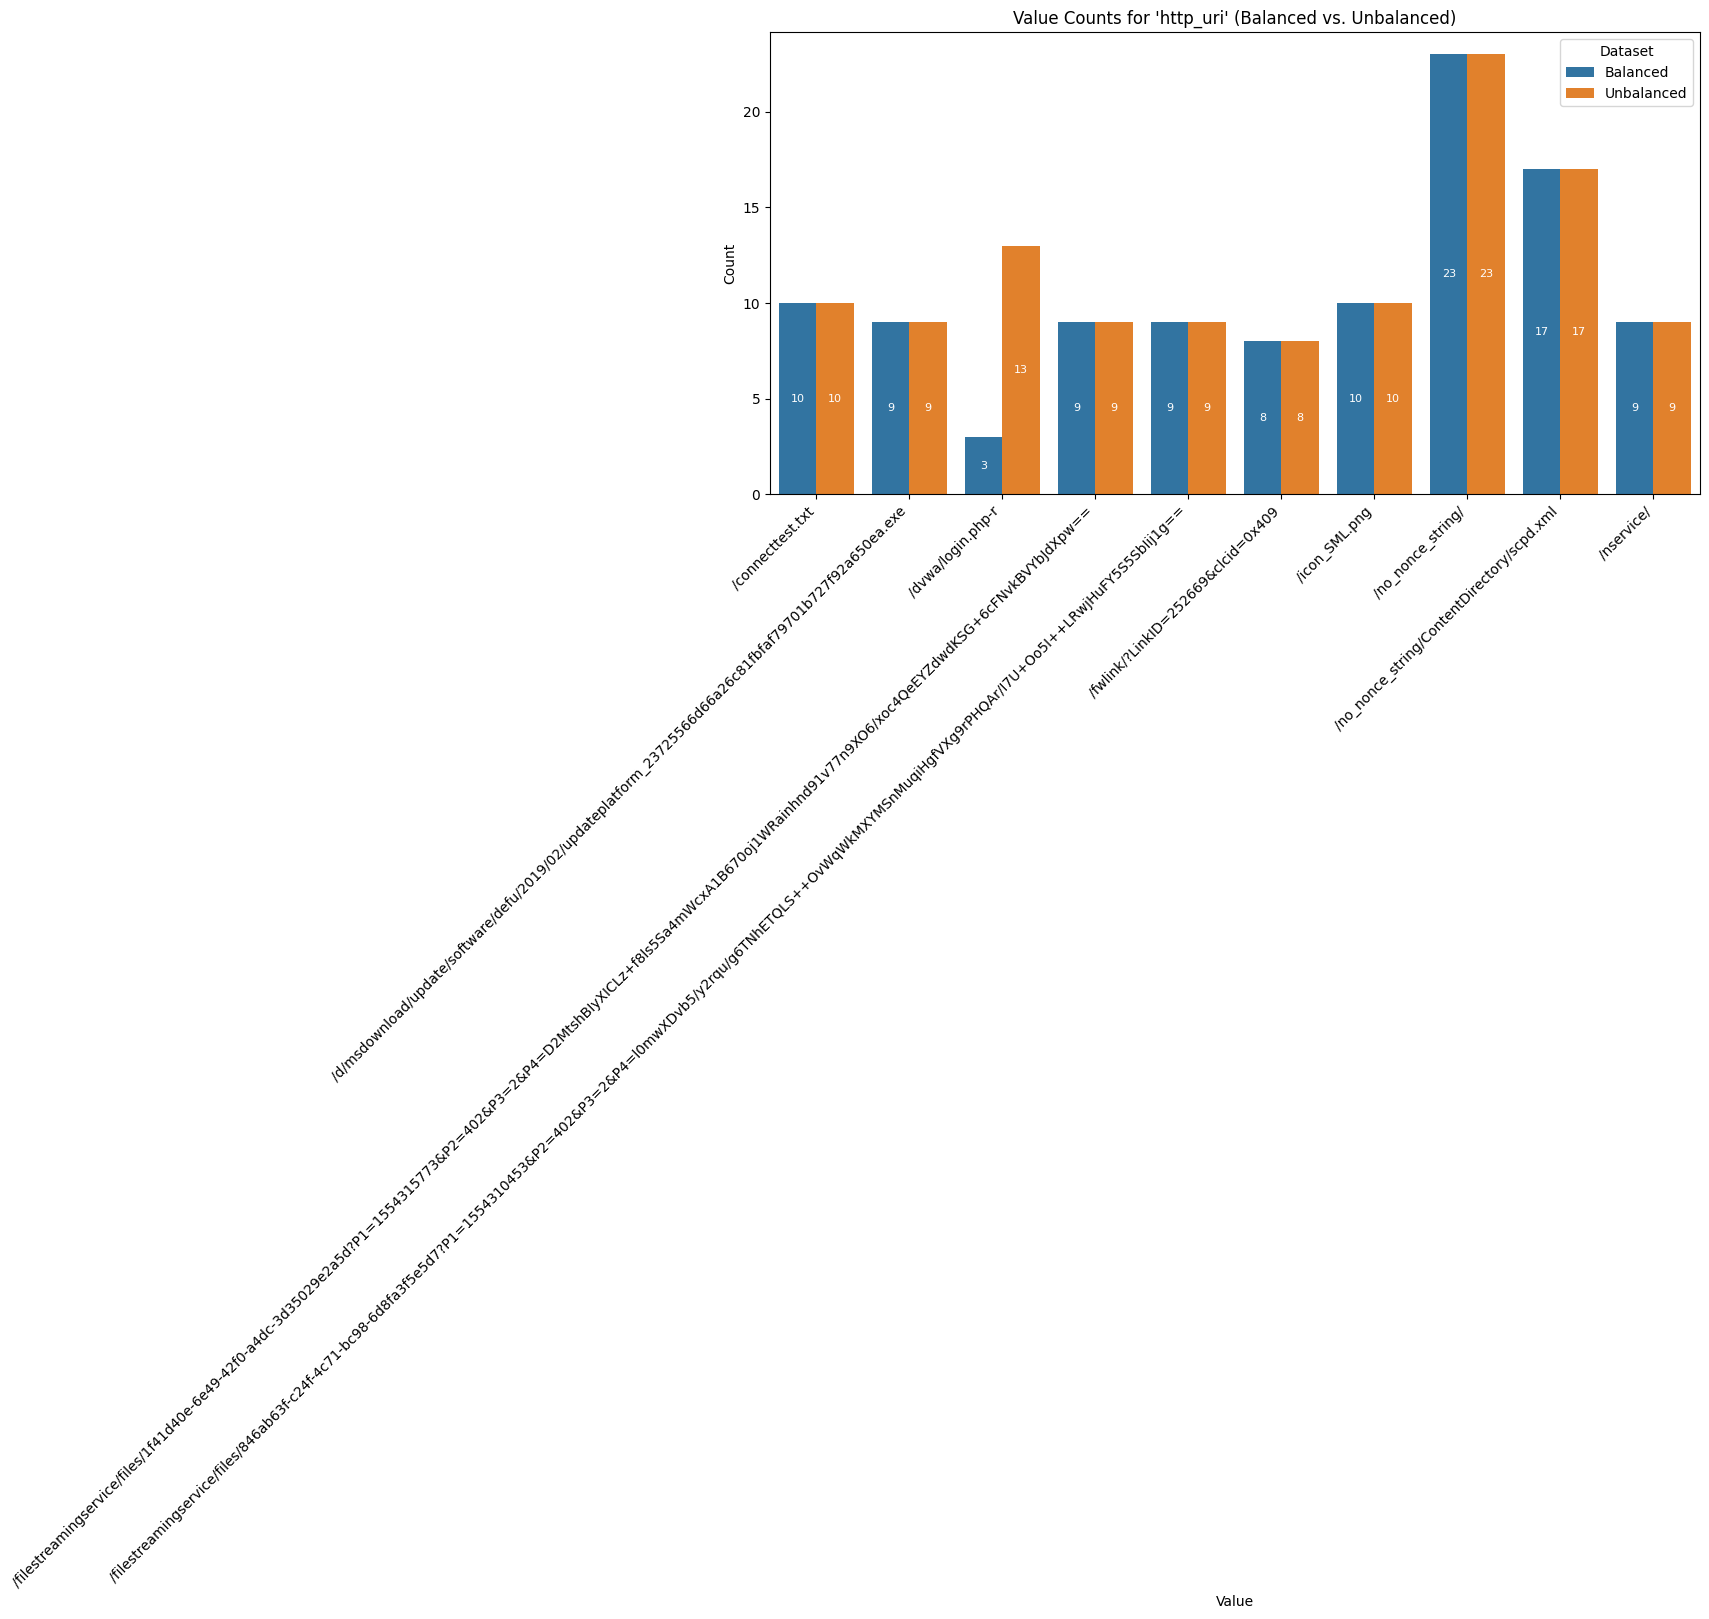

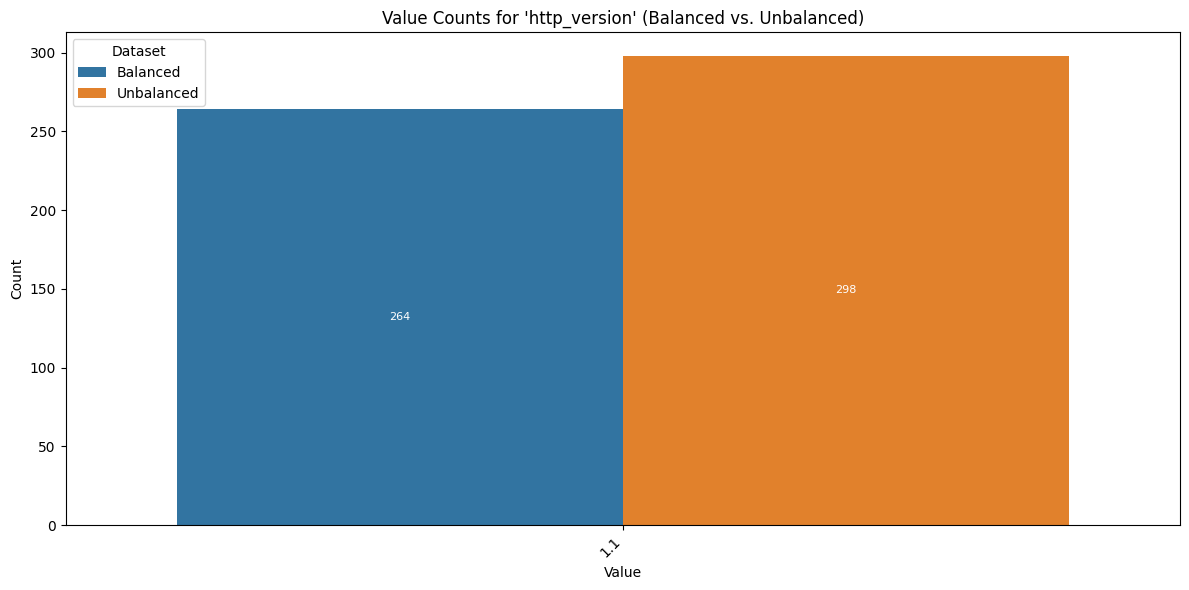

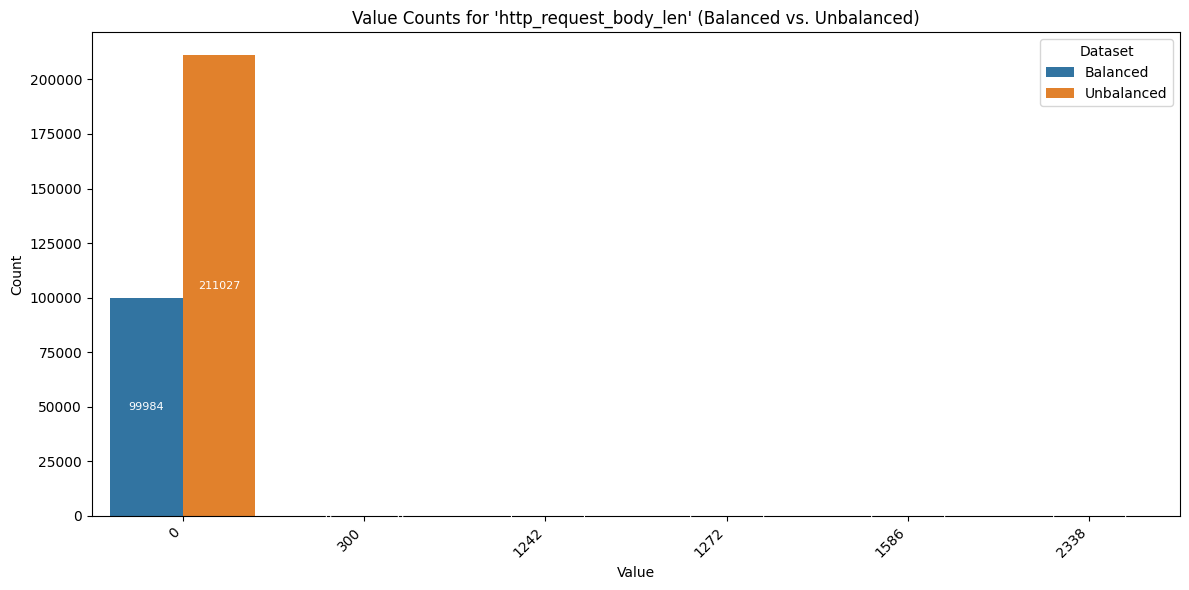

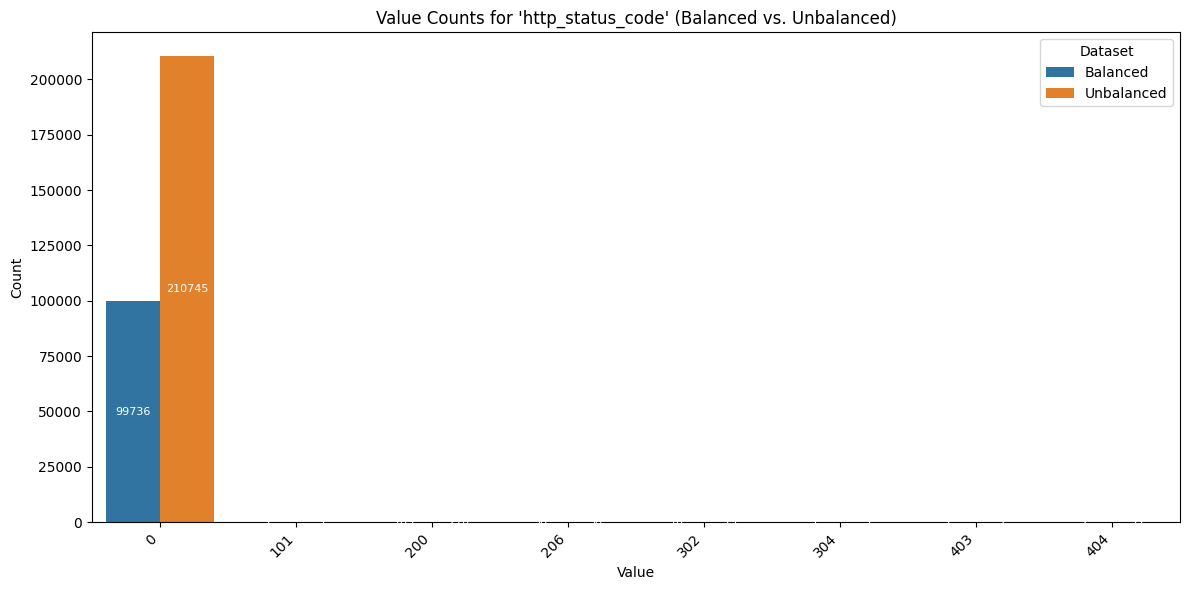

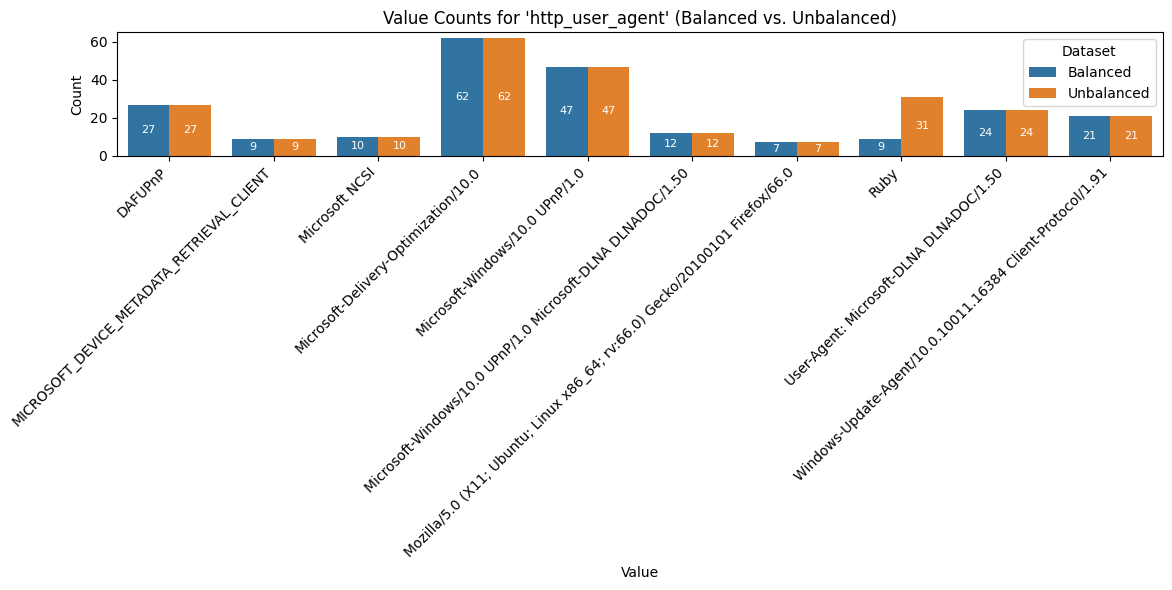

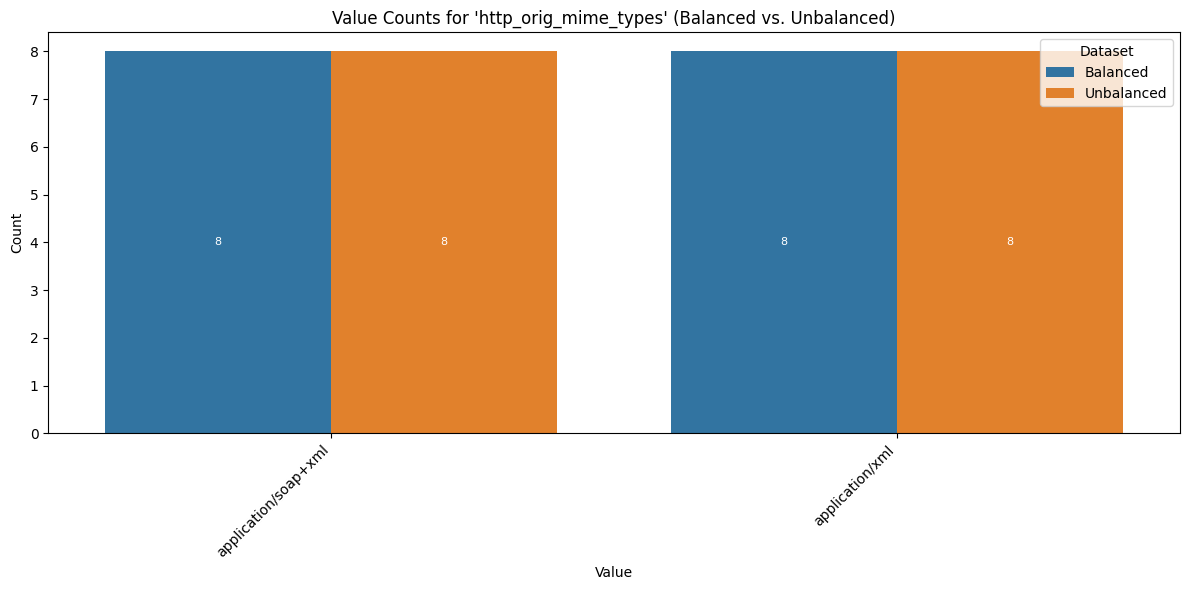

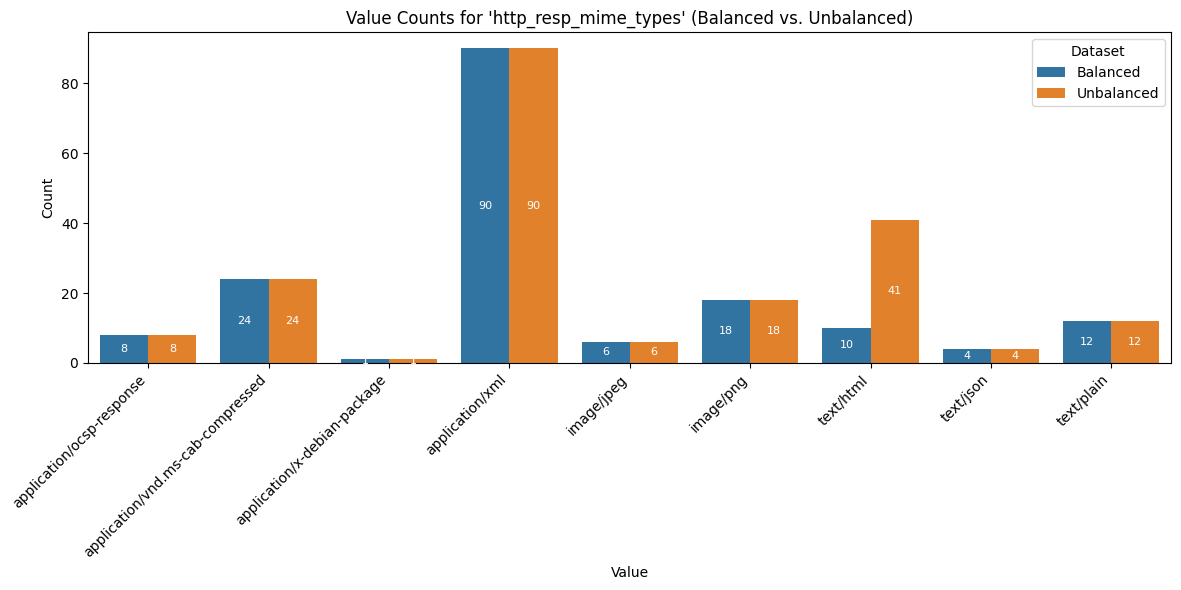

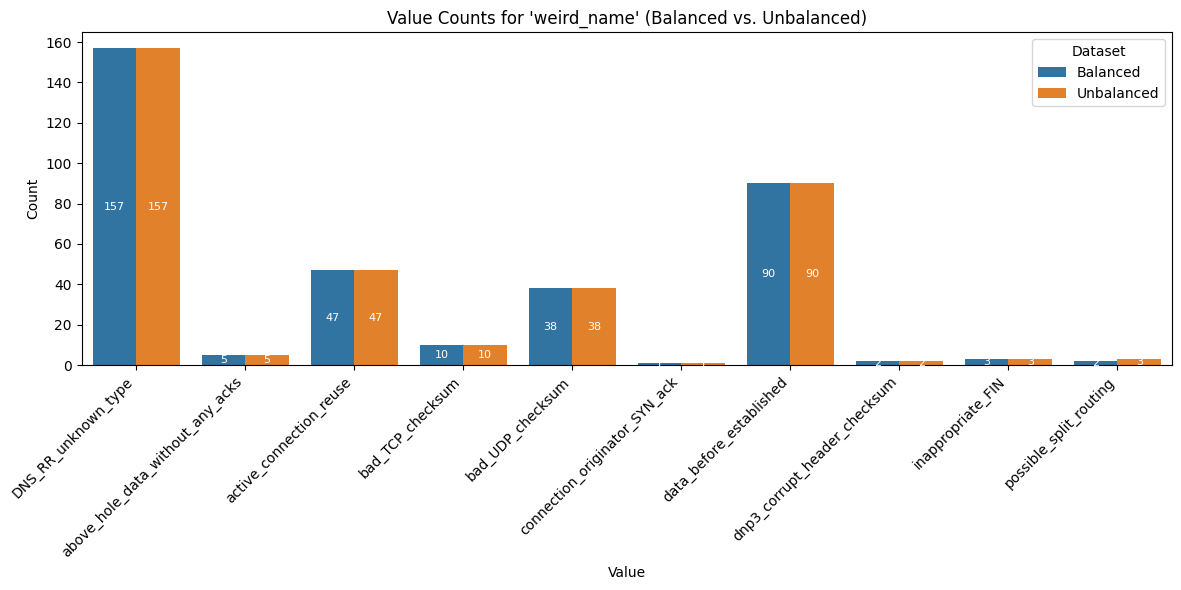

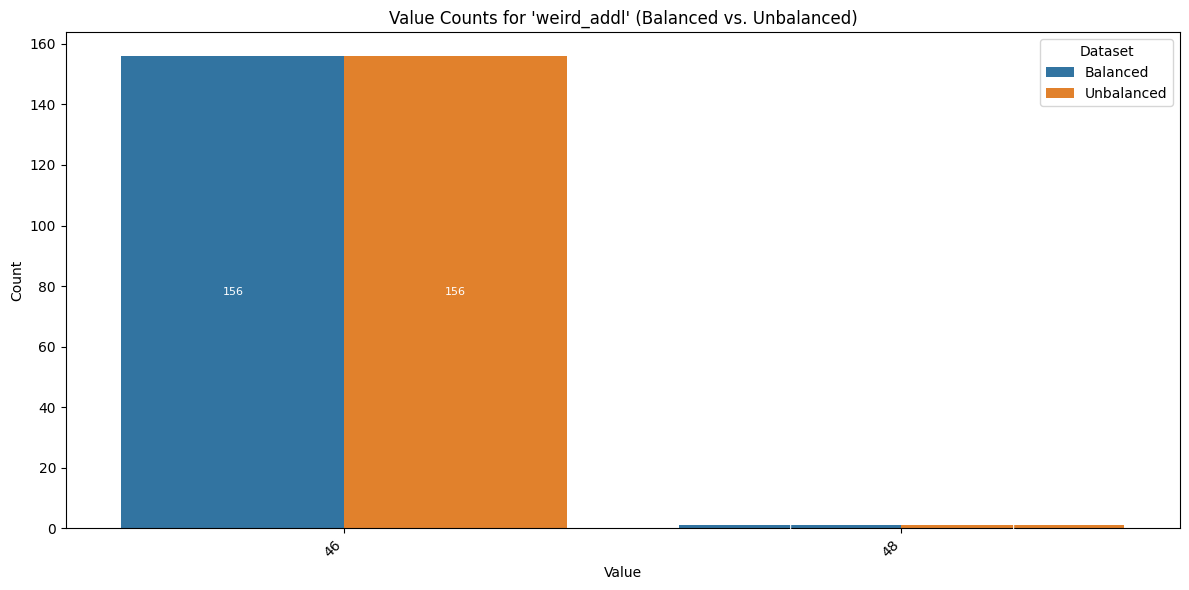

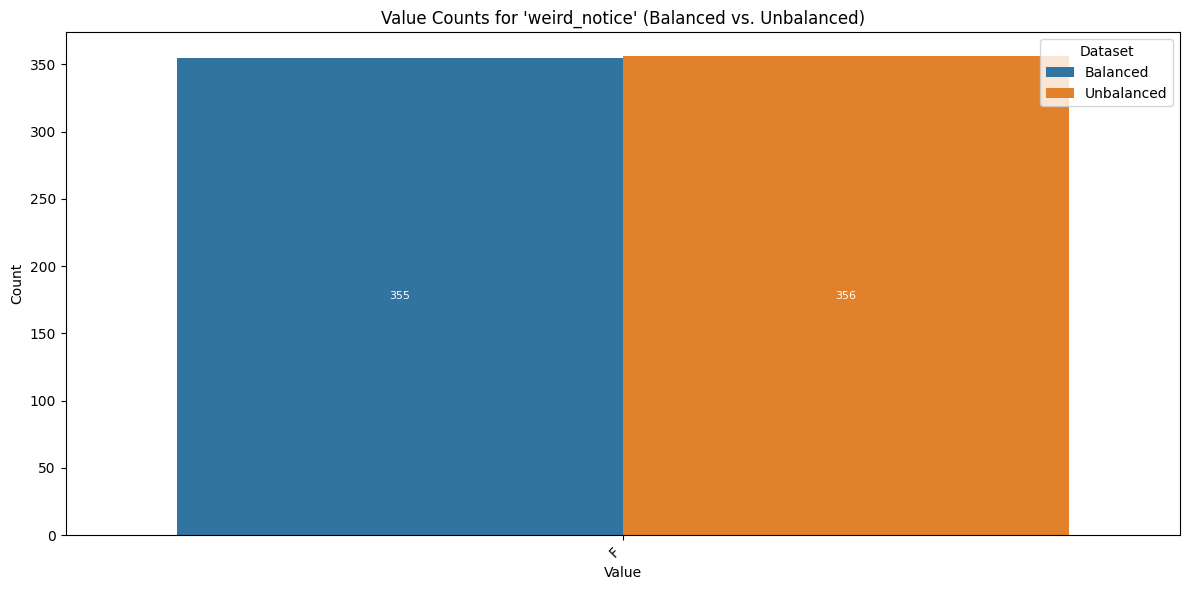

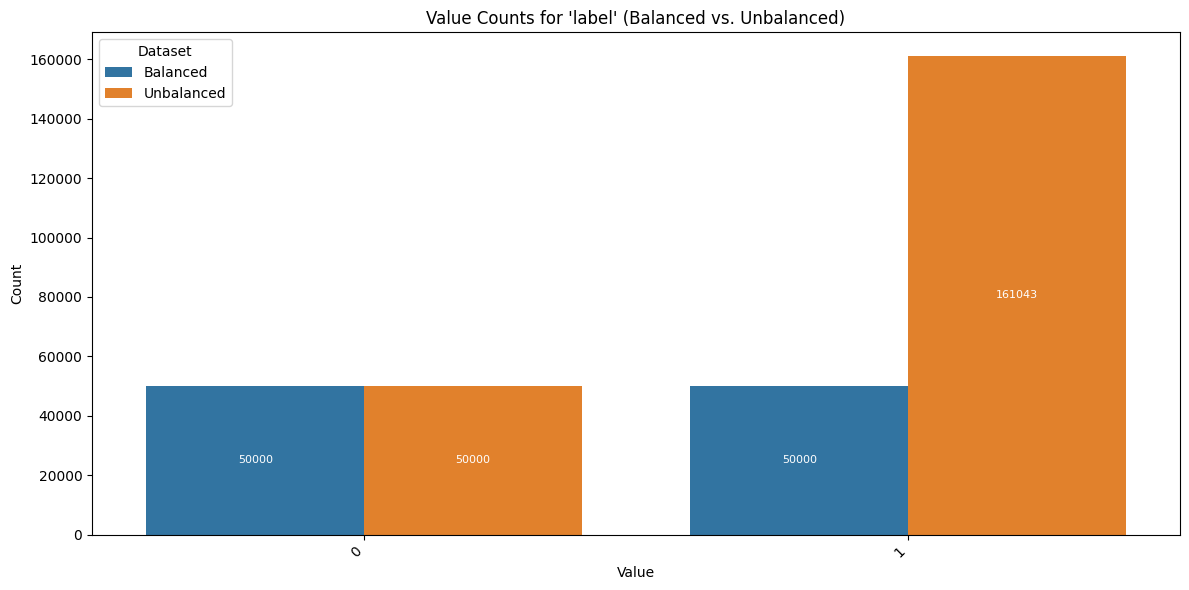

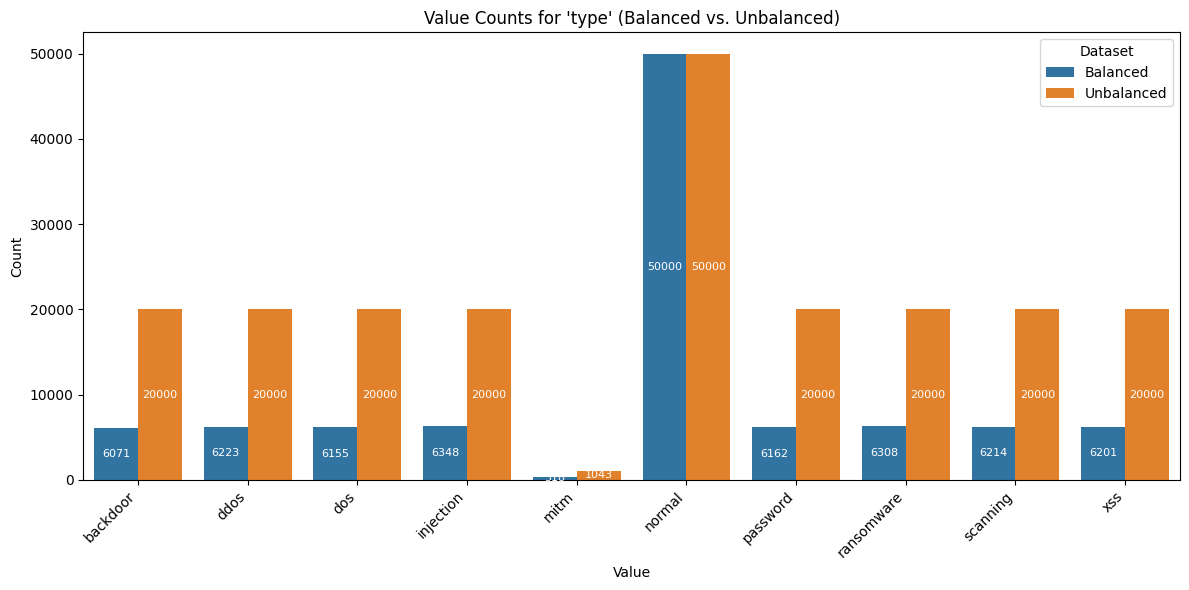